# Creating pendulum animation

In [140]:
import cv2
import numpy as np
# frame parameters
height = 96
width = 192
period = 3
fr = period*50
L = 50
r = 10
# background
pad = 127*np.ones((height,width,3),dtype='uint8')
pad = cv2.line(pad,(0,20),(width,20),(0,0,0),2)
pad = cv2.circle(pad,(int(width/2),20), 4, (255,255,0),-1)
t = np.linspace(0,period,fr)
t = np.mod(t,1)
t[t>.5] = 1-t[t>.5]
theta = np.pi/2*np.cos(2*np.pi*t)
# calculate pendulum location
x = (int(width/2) + L*np.sin(theta)).astype('int')
y = (20+L*np.cos(theta)).astype('int')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
vid = cv2.VideoWriter('Pendulum.avi',fourcc, 15, (width,height))  
# creating frames
for i in range(fr):
  img = pad.copy()
  img = cv2.line(img,(int(width/2),20),(x[i],y[i]),(255,0,0),2)
  img = cv2.circle(img,(x[i],y[i]), r, (0,0,255),-1)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  vid.write(img)

vid.release()

# Reading pendulum animation

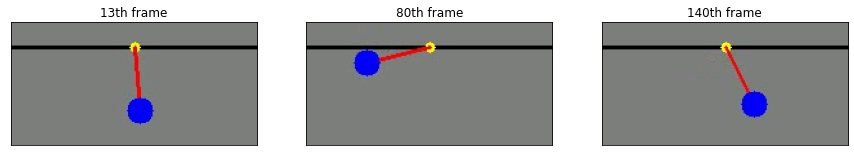

In [141]:
import matplotlib.pyplot as plt
cap = cv2.VideoCapture('/content/Pendulum.avi')
frame = np.zeros((fr,height,width,3),'uint8')
k = [13,80,140]
# reading frames
for i in range(fr):
  _,f = cap.read()
  frame[i] = cv2.cvtColor(f,cv2.COLOR_BGR2RGB)

# show some frames
plt.figure(figsize=(15,10))
for j,i in enumerate(k):
  plt.subplot(1,3,j+1)
  plt.imshow(frame[i-1])
  plt.yticks([])
  plt.xticks([])
  plt.title(str(i)+'th frame')

plt.savefig('frame_sample.jpg',dpi=300,quality=95,bbox_inches='tight')

# Creating dataset for model

In [143]:
fr_seq = 3 # sequence length
fr_train = 120 # num of train sample
fr_test = fr-fr_train-fr_seq # num of test sample
frame = frame.astype('float32')/255 # normalize data
x_train = np.zeros((fr_train,fr_seq,96, 192, 3))
y_train = np.zeros((fr_train,96,192,3))
x_test = np.zeros((fr_test,fr_seq,96, 192, 3))
y_test = np.zeros((fr_test,96,192,3))
# create train data
for i in range(fr_train):
  x_train[i] = frame[i:i+fr_seq]
  y_train[i] = frame[i+fr_seq]
# create test data
for i in range(fr_test):
  x_test[i] = frame[i+fr_train:i+fr_train+fr_seq]
  y_test[i] = frame[i+fr_train+fr_seq]

# Create and fit model

In [172]:
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D,Flatten,MaxPool2D,TimeDistributed
from tensorflow.keras.layers import UpSampling2D,Reshape,LSTM,GRU,SimpleRNN
from keras.models import Sequential
import time
t1 = time.time()
model = Sequential()
# featrue extraction layers
model.add(TimeDistributed(Conv2D(200,(3,3),padding='same',activation='relu'),
                          input_shape=(None,96,192,3)))
model.add(TimeDistributed(MaxPool2D((2, 2))))
model.add(TimeDistributed(Conv2D(100,(3,3),padding='same',activation='relu')))
model.add(TimeDistributed(MaxPool2D((2, 2))))
model.add(TimeDistributed(Conv2D(50,(3,3),padding='same',activation='relu')))
model.add(TimeDistributed(MaxPool2D((2, 2))))
model.add(TimeDistributed(Flatten()))
# recurrent layers
model.add(LSTM(10*24,activation='relu',return_sequences=True))
model.add(LSTM(36*24,activation='relu'))
# decoding layers
model.add(Reshape((12,24,3)))
model.add(Conv2D(50,(3,3),padding='same',activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(100,(3,3),padding='same',activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(200,(3,3),padding='same',activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(3,(3,3),padding='same',activation='relu'))
# model.summary()
# compile and fit model
model.compile(optimizer='rmsprop',loss='mse')
history = model.fit(x_train,y_train,epochs=200,batch_size=5,verbose=2)
print('\n\n Run time = %.2f s'%(time.time()-t1))

Epoch 1/200
24/24 - 3s - loss: 0.8226
Epoch 2/200
24/24 - 1s - loss: 0.0540
Epoch 3/200
24/24 - 1s - loss: 0.0529
Epoch 4/200
24/24 - 1s - loss: 0.0431
Epoch 5/200
24/24 - 1s - loss: 0.0165
Epoch 6/200
24/24 - 1s - loss: 0.0078
Epoch 7/200
24/24 - 1s - loss: 0.0068
Epoch 8/200
24/24 - 1s - loss: 0.0066
Epoch 9/200
24/24 - 1s - loss: 0.0062
Epoch 10/200
24/24 - 1s - loss: 0.0063
Epoch 11/200
24/24 - 1s - loss: 0.0060
Epoch 12/200
24/24 - 1s - loss: 0.0057
Epoch 13/200
24/24 - 1s - loss: 0.0051
Epoch 14/200
24/24 - 1s - loss: 0.0048
Epoch 15/200
24/24 - 1s - loss: 0.0045
Epoch 16/200
24/24 - 1s - loss: 0.0040
Epoch 17/200
24/24 - 1s - loss: 0.0035
Epoch 18/200
24/24 - 1s - loss: 0.0030
Epoch 19/200
24/24 - 1s - loss: 0.0028
Epoch 20/200
24/24 - 1s - loss: 0.0028
Epoch 21/200
24/24 - 1s - loss: 0.0025
Epoch 22/200
24/24 - 1s - loss: 0.0023
Epoch 23/200
24/24 - 1s - loss: 0.0023
Epoch 24/200
24/24 - 1s - loss: 0.0021
Epoch 25/200
24/24 - 1s - loss: 0.0021
Epoch 26/200
24/24 - 1s - loss: 0.

# Results of trained model

Loss for tarin data = 0.000409
Loss for test data = 0.000578


Text(0.5, 1.0, 'MSE loss for RMSprop')

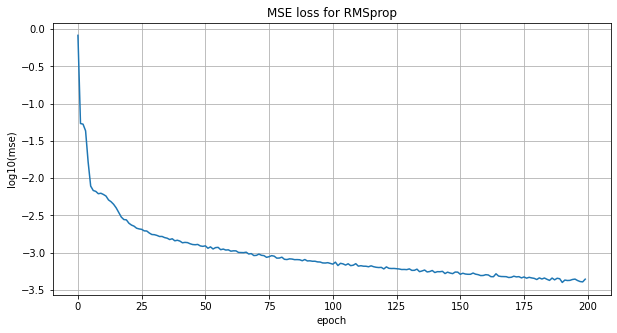

In [174]:
l_train = model.evaluate(x_train,y_train,verbose=0)
l_test = model.evaluate(x_test,y_test,verbose=0)
print('Loss for tarin data = %f'%l_train)
print('Loss for test data = %f'%l_test)
plt.figure(figsize=(10,5))
plt.plot(np.log10(history.history['loss']))
plt.grid()
plt.xlabel('epoch')
plt.ylabel('log10(mse)')
plt.title('MSE loss for RMSprop')
# plt.savefig('loss_rmsprop.jpg',dpi=300,quality=95,bbox_inches='tight')

# Showing predicted images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


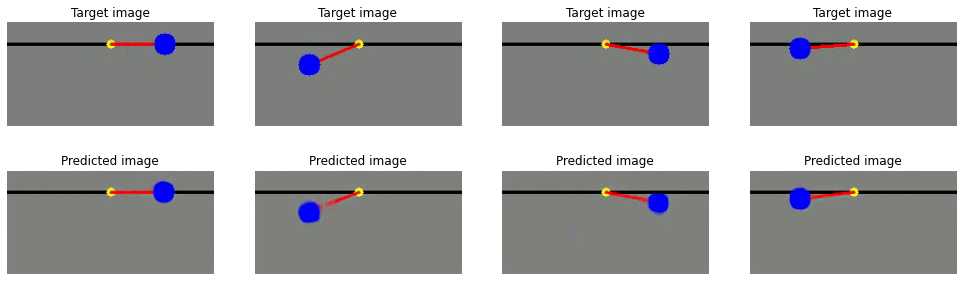

In [175]:
import matplotlib.pyplot as plt
# predict test data
y_pred = model.predict(x_test)
k = np.random.choice(np.arange(fr_test),4,replace=False)
plt.figure(figsize=(17,5))
# showing target and predicted images
for j,i in enumerate(k):
  plt.subplot(2,4,j+1)
  plt.imshow(y_test[i].reshape(96,192,3))
  plt.title('Target image')
  plt.axis('off')
  plt.subplot(2,4,j+5)
  plt.imshow(y_pred[i].reshape(96,192,3))
  plt.title('Predicted image')
  plt.axis('off')

plt.savefig('model_result.jpg',dpi=300,quality=95,bbox_inches='tight')

# Frame prediction with animation

In [215]:
Frame = frame.copy()
seq = np.zeros((1,3,96,192,3))
# predeicted frames
fram_pred = []
x_input = Frame[:3].reshape(1,3,96,192,3)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
vid = cv2.VideoWriter('Pendulum_predict.avi',fourcc, 15, (2*width,height))  
# predict 1st frame
y_pred = model.predict(x_input)
fram_pred.append(y_pred)
img = (255*y_pred)
img[img>255] = 255
img = img.astype('uint8').reshape(96,192,3)
img = cv2.putText(img,'predict',(78,10),cv2.FONT_HERSHEY_SIMPLEX,.4,
                  (0,0,0),1,cv2.LINE_8)
temp = (255*y_train[0]).astype('uint8').reshape(96,192,3)
temp = cv2.putText(temp,'target',(78,10),cv2.FONT_HERSHEY_SIMPLEX,.4,
                  (0,0,0),1,cv2.LINE_8)
img2 = np.concatenate((temp,img),1)
vid.write(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
seq[:,0:2] = x_input[:,1:3]
seq[:,2] = y_pred.reshape(1,1,96,192,3)
# predict 49 more frames
for i in range(49):
  y_pred = model.predict(seq)
  fram_pred.append(y_pred)
  img = (255*y_pred)
  img[img>255] = 255
  img = img.astype('uint8').reshape(96,192,3)
  img = cv2.putText(img,'predict',(78,10),cv2.FONT_HERSHEY_SIMPLEX,.4,
                  (0,0,0),1,cv2.LINE_8)
  temp = (255*y_train[i+1]).astype('uint8').reshape(96,192,3)
  temp = cv2.putText(temp,'target',(78,10),cv2.FONT_HERSHEY_SIMPLEX,.4,
                  (0,0,0),1,cv2.LINE_8)
  img2 = np.concatenate((temp,img),1)
  vid.write(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))  
  seq[:,0:2] = seq[:,1:3]
  seq[:,2] = y_pred.reshape(1,1,96,192,3)

vid.release()

# Show predicted images of part 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


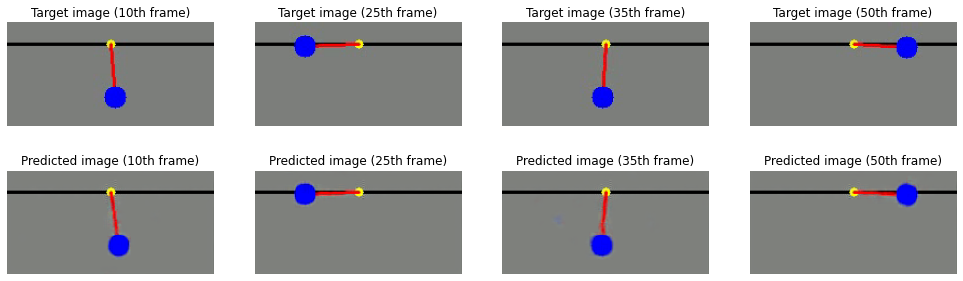

In [200]:
k = [10,25,35,50]
plt.figure(figsize=(17,5))
# showing target and predicted images
for j,i in enumerate(k):
  plt.subplot(2,4,j+1)
  plt.imshow(y_train[i-1].reshape(96,192,3))
  plt.title('Target image ('+str(i)+'th '+'frame)')
  plt.axis('off')
  plt.subplot(2,4,j+5)
  plt.imshow(fram_pred[i-1].reshape(96,192,3))
  plt.title('Predicted image ('+str(i)+'th '+'frame)')
  plt.axis('off')

plt.savefig('part7_result.jpg',dpi=300,quality=95,bbox_inches='tight')